# Left ventricle segmentation

Here we use the [EchoNetDynamic](https://echonet.github.io/dynamic/) model within the zea framework to segment left ventricle in echocardiograms. Note that in this notebook, we use the original model, but perform inference on the [CAMUS](https://www.creatis.insa-lyon.fr/Challenge/camus/) dataset, which is a different dataset than the one used to train the model.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/left_ventricle_segmentation_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/left_ventricle_segmentation_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/echonet-dynamic)

In [ ]:
%%capture
%pip install zea

In [1]:
import os

# NOTE: should be `tensorflow` or `jax` for EchoNetDynamic
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
from keras import ops

from zea import init_device, log
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.tools.selection_tool import add_shape_from_mask
from zea.utils import translate
from zea.visualize import plot_image_grid, set_mpl_style

init_device(verbose=False)
set_mpl_style()

E0000 00:00:1757577038.897751   41338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757577038.901850   41338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757577038.914035   41338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757577038.914055   41338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757577038.914057   41338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757577038.914059   41338 computation_placer.cc:177] computation placer already registered. Please check linka

zea: Using backend 'tensorflow'


E0000 00:00:1757577047.823990   41338 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757577047.826269   41338 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Load EchoNetDynamic from `zeahub`

In [2]:
from zea.models.echonet import EchoNetDynamic, INFERENCE_SIZE

presets = list(EchoNetDynamic.presets.keys())
log.info(f"Available built-in zea presets for EchoNetDynamic: {presets}")

model = EchoNetDynamic.from_preset("echonet-dynamic")

zea: Available built-in zea presets for EchoNetDynamic: ['echonet-dynamic']


Now let's load some data (for more info see the [zea_data_example](../data/zea_data_example.ipynb) notebook), and perform inference on the data to segment the left ventricle. Note that the performance of the model is not as good on the CAMUS dataset as it is on the original EchoNetDynamic dataset, but it still provides a good example of how to use the model within the zea framework.

zea: Using pregenerated dataset info file: /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on September 11, 2025
zea: Remove /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.
zea: H5Generator: Shuffled data.


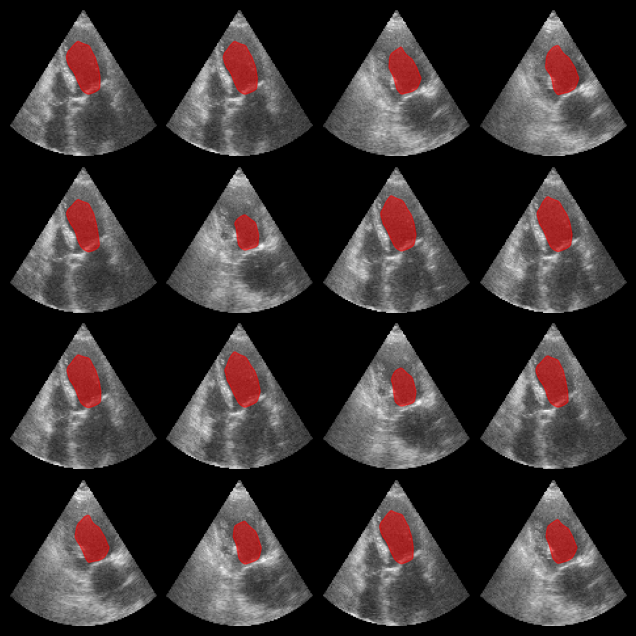

In [4]:
n_imgs = 16
val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image_sc",
    batch_size=n_imgs,
    shuffle=True,
    image_range=[-60, 0],
    normalization_range=[-1, 1],
    image_size=(INFERENCE_SIZE, INFERENCE_SIZE),
    resize_type="resize",
    seed=42,
)

batch = next(iter(val_dataset))
# grayscale to RGB for the EchoNetDynamic model
rgb_batch = ops.concatenate([batch, batch, batch], axis=-1)

masks = model(rgb_batch)
masks = ops.squeeze(masks, axis=-1)
masks = ops.convert_to_numpy(masks)

batch = translate(rgb_batch, [-1, 1], [0, 1])
fig, _ = plot_image_grid(batch, vmin=0, vmax=1)
axes = fig.axes[:n_imgs]
for ax, mask in zip(axes, masks):
    add_shape_from_mask(ax, mask, color="red", alpha=0.5)

plt.show()